<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-библиотек,-моделей-и-данных" data-toc-modified-id="Загрузка-библиотек,-моделей-и-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка библиотек, моделей и данных</a></span></li><li><span><a href="#Анализ-и-предобработка" data-toc-modified-id="Анализ-и-предобработка-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Анализ и предобработка</a></span><ul class="toc-item"><li><span><a href="#Подготовка-для-TFIDF" data-toc-modified-id="Подготовка-для-TFIDF-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Подготовка для TFIDF</a></span></li><li><span><a href="#Подготовка-для-BERT" data-toc-modified-id="Подготовка-для-BERT-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Подготовка для BERT</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модели-на-базе-TD-IDF" data-toc-modified-id="Модели-на-базе-TD-IDF-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модели на базе TD IDF</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#lgboost" data-toc-modified-id="lgboost-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>lgboost</a></span></li></ul></li><li><span><a href="#Модели-на-базе-BERT" data-toc-modified-id="Модели-на-базе-BERT-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модели на базе BERT</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

**Часть проекта (просчет фичей и батчей BERT) выполнена с использованием мощностей google collab с аппаратным ускорителем gpu, полученные фичи консервировались в байтник, а далее проект выполнялся на локальной машине. Все что закомментировано - относится к вычислению BERT - раскомментируйте если необходимо их вычислить заново**

## Подготовка

### Загрузка библиотек, моделей и данных

In [1]:
#pip install transformers

In [2]:
#pip install cuda-python

In [3]:
#import cuda
#import torch
#import transformers as ppb
#from transformers import AutoModel, AutoTokenizer 
import numpy as np
import pandas as pd
from tqdm import notebook
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve,roc_curve, plot_roc_curve
from sklearn.metrics import precision_recall_curve, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
import lightgbm as lgb

import pickle

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet

import re

import urllib.request

#from google.colab import output
#output.enable_custom_widget_manager()

#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
# Скачивание вычисленныx заранее фичией BERT с google drive
url = 'https://drive.google.com/u/0/uc?id=1g5S9Fl4JFLPSmdBoeDFau6g4YX8K3BMH&export=download&confirm=t&uuid=2f5b6cc9-2439-4e64-915c-d84a23f10d17&at=ALgDtsxqaFIJ5Xo2b0qvVsmht09G:1676203473476'
urllib.request.urlretrieve(url, 'features')

('features', <http.client.HTTPMessage at 0x1b8e3094160>)

In [5]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
#model_name = "unitary/toxic-bert" 

#model = AutoModel.from_pretrained(model_name)
#tokenizer = AutoTokenizer.from_pretrained(model_name)

In [7]:
#df = pd.read_csv('drive/MyDrive/toxic_comments.csv')
df = pd.read_csv('datasets/toxic_comments.csv')

### Анализ и предобработка

In [8]:
df.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [9]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [10]:
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Датасет конечно не сильно сбалансирован, но приемлимо, пока что исправлять это не будем. Подготовим датасет с помощью TF-IDF 

#### Подготовка для TFIDF

In [11]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list])


def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z\']', ' ', text) 
    clear_text = clear_text.split()
    return " ".join(clear_text)

In [12]:
tqdm.pandas()
df['lem'] = df['text'].progress_apply(
    lambda x: lemmatize(clear_text(x.lower()))
)
df_td_idf = df.copy()

  0%|          | 0/159292 [00:00<?, ?it/s]

In [13]:
stopwords = set(nltk_stopwords.words('english'))

#### Подготовка для BERT

In [14]:
df = df[:159200]

In [15]:
# Блоки вычисления токенов и фичей для BERT в google collab
#
#tokenized = df['text'].apply(
#    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))
#
#max_len = 0
#for i in tokenized.values:
#    if len(i) > max_len:
#        max_len = len(i)
#
#input_ids = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
#
#attention_mask = np.where(input_ids != 0, 1, 0)

In [16]:
#input_ids.shape

In [17]:
#from tqdm import notebook
#batch_size = 100
#embeddings = [] 
#for i in notebook.tqdm(range(input_ids.shape[0] // batch_size)):
#        batch = torch.LongTensor(input_ids[batch_size*i:batch_size*(i+1)]).cuda() # закидываем тензор на GPU
#        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).cuda()
#
#        with torch.no_grad():
#            model.cuda()
#            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
#
#        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy()) # перевод обратно на проц, чтобы в нумпай кинуть
#        del batch
#        del attention_mask_batch
#        del batch_embeddings
#
#features = np.concatenate(embeddings)

In [18]:
#features = np.concatenate(embeddings)

In [19]:
#with open('drive/MyDrive/features', 'wb') as f:
#    pickle.dump(features, f)

In [20]:
#with open('drive/MyDrive/features', 'rb') as f:
#    features = pickle.load(f)
#with open('datasets/features', 'rb') as f:
#    features = pickle.load(f)

# Объявление заранее вычесленных фичей
with open('features', 'rb') as f:
    features = pickle.load(f)

In [21]:
features.shape

(159200, 768)

## Обучение

### Модели на базе TD IDF

#### Логистическая регрессия

In [22]:
X_train_td_idf, x_test_td_idf, y_train_td_idf, y_test_td_idf = train_test_split(
    df_td_idf['lem'], df_td_idf['toxic'], test_size=0.1
)

In [23]:
%%time
pipe = Pipeline(
    [('pre', TfidfVectorizer(stop_words=stopwords)),
     ('clf', LogisticRegression(max_iter=10000))]
)
grid={
    'clf__C':[0.1, 1, 10]
}

linear_model_td_idf = GridSearchCV(
    pipe, 
    grid, cv=3, 
    scoring='f1', 
    n_jobs=-1
)
linear_model_td_idf.fit(X_train_td_idf, y_train_td_idf);

Wall time: 49.6 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pre',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    'aren',
           

In [24]:
linear_model_td_idf.best_score_

0.7674618954986121

In [25]:
linear_model_td_idf.best_params_

{'clf__C': 10}

#### lgboost

In [26]:
%%time

pipe = Pipeline(
    [('pre', TfidfVectorizer(stop_words=stopwords)),
     ('clf', lgb.LGBMClassifier(n_estimators=100, n_jobs=-1))]
)

grid={
    'clf__max_depth':[6, 8, 10],
    'clf__learning_rate': [0.3, 0.5],
}

lgboost_model_td_idf = GridSearchCV(
    pipe, 
    grid, cv=3, 
    scoring='f1', 
    n_jobs=-1
)

lgboost_model_td_idf.fit(X_train_td_idf, y_train_td_idf);

Wall time: 2min 55s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pre',
                                        TfidfVectorizer(stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all', 'am',
                                                                    'an', 'and',
                                                                    'any',
                                                                    'are',
                                                                    'aren',
           

In [27]:
lgboost_model_td_idf.best_score_

0.7532155131504762

In [28]:
lgboost_model_td_idf.best_params_

{'clf__learning_rate': 0.5, 'clf__max_depth': 10}

### Модели на базе BERT

In [29]:
X_train, x_test, y_train, y_test = train_test_split(features, df['toxic'], test_size=0.1)

Модель логистической регрессии с перебором гиперпараметров

In [30]:
%%time
grid={
    'C':[0.1, 1, 10]
}

linear_model = GridSearchCV(
    LogisticRegression(max_iter=10000), 
    grid, cv=3, 
    scoring='f1', 
    n_jobs=-1
)
linear_model.fit(X_train, y_train);

Wall time: 7min 59s


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10]}, scoring='f1')

In [31]:
linear_model.best_score_

0.9472886554716071

In [32]:
linear_model.best_params_

{'C': 0.1}

Наилучшей показала себя модель логистической регрессии на базе BERT (С = 0.1) с f1 = 0.9472. Протестируем ее

## Тестирование

In [36]:
model = linear_model
y_pred = model.predict(x_test)
print(f'accuracy: {accuracy_score(y_test, y_pred):0.4f}')
print(f'precisison: {precision_score(y_test, y_pred):0.4f}')
print(f'recall: {recall_score(y_test, y_pred):0.4f}')
print(f'F1: {f1_score(y_test, y_pred):0.4f}')

accuracy: 0.9897
precisison: 0.9485
recall: 0.9473
F1: 0.9479


In [37]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

print('accuracy dummy', accuracy_score(y_test, dummy.predict(x_test)))

accuracy dummy 0.9011306532663317


В сравнении с наивной моделью наша показывает отличный accuracy!

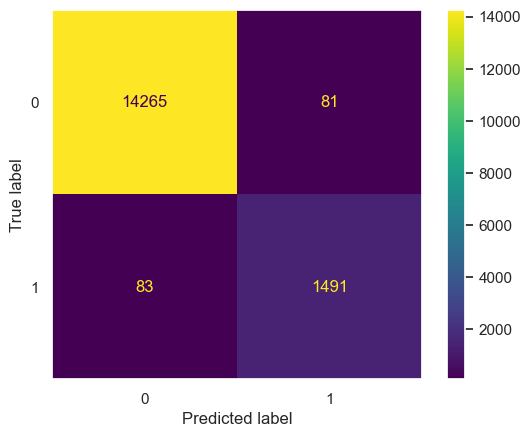

In [38]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.grid(False)
plt.show()

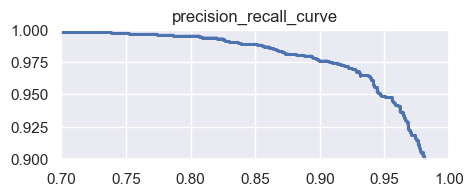

In [39]:
probas = model.predict_proba(x_test)[:,1]
precision,recall,thresholds = precision_recall_curve(y_test,probas)

plt.figure(figsize=(5,5))
plt.plot(recall,precision)
plt.scatter(recall,precision, s=1)
plt.gca().set_aspect('equal')
plt.xlim([0.7, 1])
plt.ylim([0.9, 1])
plt.title('precision_recall_curve')
plt.show()

Модель практически идеальна. Отфильтровать большое число негатива при этом не потревожив обычных пользователей будет не сложно. Если считать, что токсичные комментарии встречаются так же часто как и в датасете(~10%), то необходима максимальная точность в ущерб реколу. Это утверждение опирается на то, что обычные пользователи могут жаловаться на комментарий, и он будет отправляться модератору, это лучше, чем отправлять модератору тонну обычных комментариев и конечно дешевле.

Допустим модератору приходит 10 комментариев. 

а) Мы хотим, чтобы модератору практически не отправлялись нетоксичные, то нам необходима точка precision ~ 1, recall получится ~ 0.75, то есть 75% негатива мы сразу отфильтровываем модеру

б) Мы хотим, чтобы модератору отправлялись нетоксичные комментарии не более 1, тогда нам необходима точка precision ~ 0.9, recall получится ~ 0.98, то есть 98% негатива мы сразу отфильтровываем модеру

C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


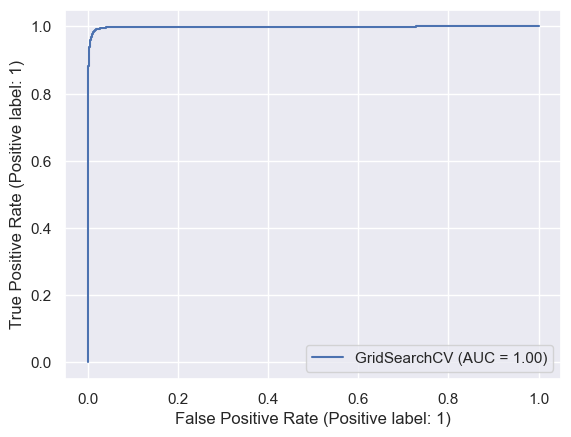

In [40]:
plot_roc_curve(model, x_test, y_test)

In [41]:
print("roc_auc:", roc_auc_score(y_test, y_pred))

roc_auc: 0.9708109667925623


## Выводы

* Обучены модели логистической регрессии и градиентного бустинга с перебором параметров на несбалансированном датасете с использованием фичей полученных из BERT и TD-IDF
* Проанализирована наилучшая модель - логистическая регрессия(С=10) на фичах TD-IDF (f1 = 0.7562 на cv=3)
* Параметры модели: accuracy: 0.9896, precisison: 0.9500, recall: 0.9483, F1: 0.9492
* Необходимо определить какая допустимая доля нетоксичных комментариев может попадать к модеру. Если 10%, то модель охватит 98% токсичных комментариев